# Day 33

In [1]:
import sys
sys.version

'3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 부스팅 방법

## 에이다 부스트

에이다 부스트와 같은 부스트(boost) 방법은 미리 정해진 모형 집합을 사용하는 것이 아니라 단계적으로 모형 집합에 포함할 개별 모형을 선택한다. 부스트 방법에서는 성능이 떨어지는 개별 모형을 weak classifier라고 한다.

또한 다수결 방법을 사용하지 않고 각 weak classifier $k$개에 대한 가중치를 주고 선형 결합하여 최종 모형인 boosted classifier $C$를 생성한다. 



$$ C_{(m-1)}(x_i) = \alpha_1k_1(x_i) + \cdots + \alpha_{m-1}k_{m-1}(x_i) $$


$$ C_{m}(x_i) = C_{(m-1)}(x_i) + \alpha_m k_m(x_i) $$


다음은 SAMME(Stagewise Additive Modeling using a Multi-class Exponential loss function) 알고리즘을 사용한 에이다 부스트 방법이다. Scikit-Learn에서는 `AdaBoostClassifier` 클래스로 구현되어 있다.

**Same방법: 새로 들어올 애한테 시험을 보게하고 시험점수가 가장 좋은 애를 끼워넣음**
그런데 벌점을 주는 형식이다. 맞으면 벌점이 없고 틀리면 벌점이 있다. 현재 commitee의 약점을 보완하는 방향으로 가려는 것이 목적이다. 즉 기존커미티가 틀린문제를 맞추어야 한다.


* $k_m$ 선택 방법
 * 가중치 오차가 가장 적은 $k_m$
$$ E = \sum_{y_i \neq k_m(x_i)} w_i^{(m)} = \sum_{y_i \neq k_m(x_i)} e^{-y_i C_{m-1}(x_i)}$$ 


* $\alpha_m$ 결정 방법

$$ \epsilon_m = \dfrac{\sum_{y_i \neq k_m(x_i)} w_i^{(m)} }{ \sum_{i=1}^N w_i^{(m)}} $$

$$ \alpha_m = \frac{1}{2}\log\left( \frac{1 - \epsilon_m}{\epsilon_m}\right) $$ 


* 정규화(regularization)를 위해 learning rate $\nu < 1$를 추가

$$ C_{m}(x_i) = C_{(m-1)}(x_i) + \nu\alpha_m k_m(x_i) $$

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

In [5]:
%%time
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=0), 
                               algorithm="SAMME", n_estimators=100)
model_ada.fit(X, y)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 122 ms


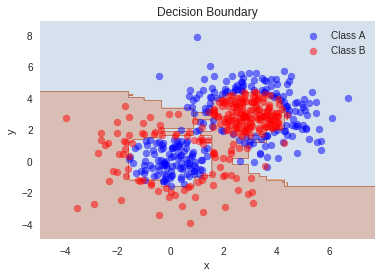

In [6]:
def plot_boost(model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

    for i, n, c in zip(range(2), "AB", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, alpha=0.5, label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')
    plt.grid(False)
    plt.show()
    
plot_boost(model_ada)

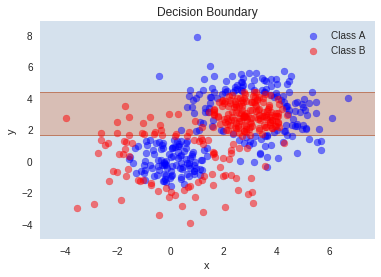

In [7]:
plot_boost(model_ada.estimators_[0])

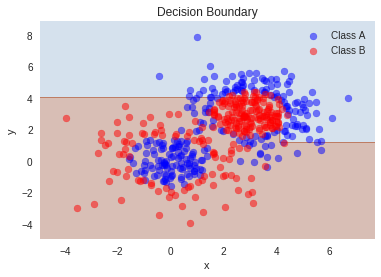

In [8]:
plot_boost(model_ada.estimators_[1])

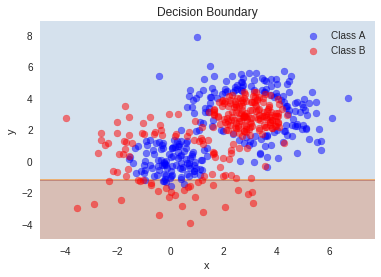

In [9]:
plot_boost(model_ada.estimators_[2])

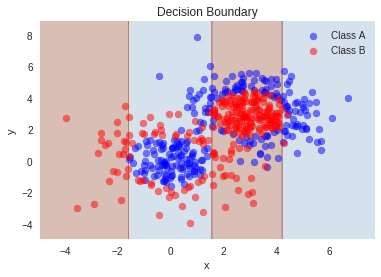

In [10]:
plot_boost(model_ada.estimators_[3])

## 그레디언트 부스트

그레이던트 부스트 모형은 최적화에 사용되는 gradient descent 방법을 응용한 모형이다. 

**Adaboost는 Heuristic한 면이 있다. 수학적으로 엄밀한 의미의 최적값을 찾는 모델을 만들자 -> Gradient Boost**

함수 $f(x)$를 최소화하는 $x$는 다음과 같이 gradient descent 방법으로 찾을 수 있다.

$$ x_{m} = x_{m-1} - \alpha_m \dfrac{df}{dx} $$

그레디언트 부스트 모형에서는 오차 함수 또는 손실 함수(loss function) $L(y, C_{m-1})$ 을 최소화하는 weak classifier $k_m$ 은 $-\tfrac{dL(y, C_{m-1})}{dC_{m-1}}$ 임을 알 수 있다. 

$$ C_{m} = C_{m-1} - \alpha_m \dfrac{dL(y, C_{m-1})}{dC_{m-1}} = C_{m-1} + \alpha_m k_m $$

따라서 그레디언트 부스트 모형에서는 다음과 같은 과정을 반복한다.

1. $-\tfrac{dL(y, C_m)}{dC_m}$ 를 target으로 하는 weak classifier $k_m$ 을 찾는다. 
2. $ \left( C_m - (C_{m-1} + \alpha_m k_m) \right)^2 $ 를 최소화하는 step size $\alpha_m$ 을 찾는다. 
3. $C_m = C_{m-1} + \alpha_m k_m$ 최종 모형을 갱신한다.

weak classifier 의 구조로는 트리를 주로 사용한다.

만약 손실함수가 오차 제곱 형태라면 gradient 는 실제 target $y$ 와   $C_{m-1}$과의 차이 즉, 잔차(residual)가 된다.

$$ L(y, C_{m-1}) = \dfrac{1}{2}(y - C_{m-1})^2 $$

$$ -\dfrac{dL(y, C_m)}{dC_m} = y - C_{m-1} $$

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

In [12]:
%%time
model_grad.fit(X, y)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 60.8 ms


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

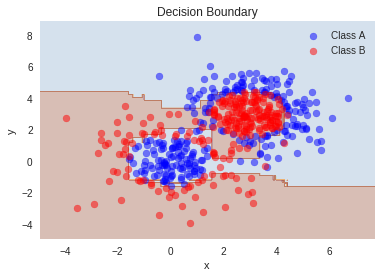

In [13]:
plot_boost(model_grad)

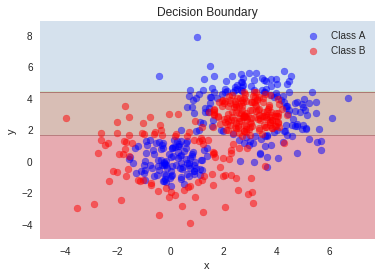

In [14]:
plot_boost(model_grad.estimators_[0][0])

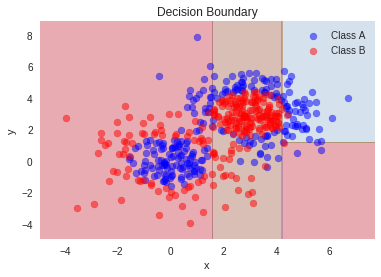

In [15]:
plot_boost(model_grad.estimators_[1][0])

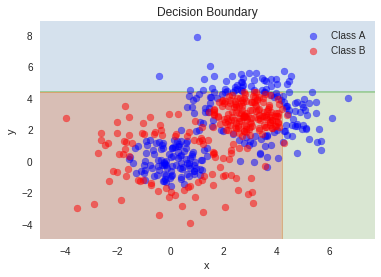

In [16]:
plot_boost(model_grad.estimators_[2][0])

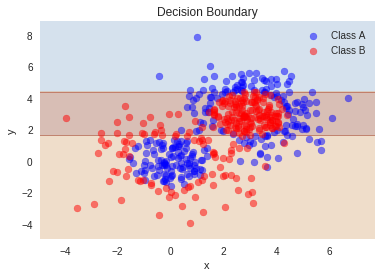

In [17]:
plot_boost(model_grad.estimators_[3][0])

### XGBoost 라이브러리

In [26]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

In [27]:
%time
model_xgb.fit(X, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

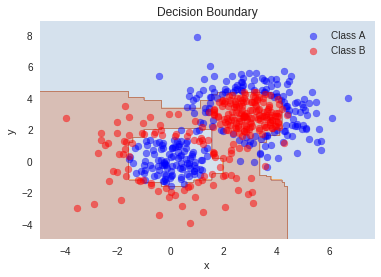

In [28]:
plot_boost(model_xgb)

In [43]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)                 


0.91300000000000003

(0, 100)

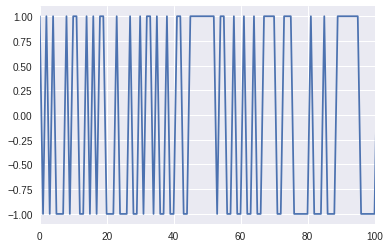

In [59]:
plt.plot(y)
plt.xlim([0,100])

# 퍼셉트론

퍼셉트론(perceptron)은 가장 오래되고 단순한 형태의 판별 함수 기반 예측 모형(discriminant function based predition model) 중 하나이다.

1962년 Rosenblatt은 동물의 신경(neuron) 구조에 기반한 퍼셉트론의 아이디어를 고안했다. 


<img src="https://datascienceschool.net/upfiles/78cccb1e0a514566916eb656c85ea397.png" style="width:70%; margin: 0 auto 0 auto;">


<img src="https://datascienceschool.net/upfiles/41974f50e89249aebe059fb4d60310aa.png" style="width:70%; margin: 0 auto 0 auto;">

퍼셉트론은 입력 $x = (1, x_1, \cdots, x_m)$에 대해 1 또는 -1의 값을 가지는  $y$를 출력하는 비선형 함수이다. 1을 포함하는 입력 요소 $x_i$에 대해 가중치 $w_i$를 곱한 후 이 값이 활성화 함수 (activation function) $f(z)$를 지나면 출력 $y$가 생성된다.

$$
y = f(w^Tx)
$$

퍼셉트론은 활성화 함수로 다음과 같은 Heaviside step function 을 가진다.

$$ y = f(z) = \begin{cases} -1, & z < 0, \\ 1, & z \ge 0 \end{cases}  $$

따라서 퍼셉트론은 $w^Tx$라는 판별함수를 가지는 판별 기반 모형이다.

## 퍼셉트론 손실 함수

퍼셉트론은 독립 변수 $x$로부터 종속 변수 $y$를 예측하는 예측 모형이므로 예측 오차 즉 손실(loss)을 최소화하는 가중치를 계산해야 한다. 

일반적으로 예측 오차는 다음과 같이 손실 함수(loss function)의 합으로 나타난다.

$$
E(w) = \sum_i L(\hat{y}, y)
$$

손실 함수(loss function) 는 실제 $y$ 값과 예측 $\hat{y}$ 값의 차이를 나타내는 함수이다. 

보통은 $L(\hat{y}, y) = -(\hat{y} - y)^2 $과 같은 손실함수를 많이 사용하지만 퍼셉트론의 경우에는 다음과 같은 손실 함수를 사용한다.

$$
L(\hat{y}, y) = \max(0,-\hat{y}y)
$$

$$
E(w) = \sum_i \max(0,-\hat{y}y) = \sum_i \max(0,-w^Tx_i y_i)
$$

이를 퍼셉트론 손실 함수(perceptron loss function)이라고 한다.



## 가중치 계산

$E(w)$를 최소화하는 $w$를 찾기 위해 $E(w)$를 $w$로 미분하여 gradient를 구하면 다음과 같다.

$$
\dfrac{dE}{dw} = - \sum_i x_i y_i
$$


gradient descent 방법을 사용하면 다음과 같이 $w$를 구할 수 있다.


$$
\begin{eqnarray}
w_{k+1} 
&=& w_{k} + \eta_k \sum_{i=1}^N x_i y_i \\
\end{eqnarray}
$$

여기에서 $eta$는 step size 또는 learning rate 이라고 부른다.


## SGD (Stochastic Gradient Descent)

퍼셉트론은 일반적인 gradient descent 방법이 아닌 SGD(Stochastic Gradient Descent) 최적화 방법을 사용한다.

SGD 최적화 방법은 정확한 gradient 인 $\dfrac{dE}{dw} = - \sum_i x_i y_i$ 대신 일부 표본 데이터만 사용한 gradient의 추정치를 이용하는 방법이다.  gradient 추정에 사용하는 표본 데이터의 갯수를 minibatch size 라고 하는데 가장 퍼셉트론은 가장 극단적인 경우로 minibatch size = 1 을 사용한다. 즉, 한번에 하나의 표본 데이터만을 이용하여 가중치를 조정한다.

$$
\begin{eqnarray}
w_{k+1} 
&=& w_{k} + \eta_k  x_i y_i \\
\end{eqnarray}
$$

이 식에서 $i$는 매 회 임의의 표본을 선택한다.

## Scikit-Learn 의 퍼셉트론 구현

Scikit-Learn 에서는 두 가지의 퍼셉트론 클래스를 제공한다. 단순한 퍼셉트론 모형인 `Perceptron` 클래스와 좀 더 다양한 옵션 인수를 제공하는 `SGDClassifier` 클래스이다.

`SGDClassifier` 클래스에서 제공하는 인수 중 일부를 소개하면 다음과 같다.

* loss : ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’,  ‘squared_epsilon_insensitive’
 * 손실 함수 

* penalty : ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’
 * 정규화 조건

* alpha, l1_ratio
 * 정규화 가중치
 
* n_iter : 
 * 최적화를 위한 반복 횟수

* eta0 : 
 * learning rate $\eta$

## Perceptron 실행 예

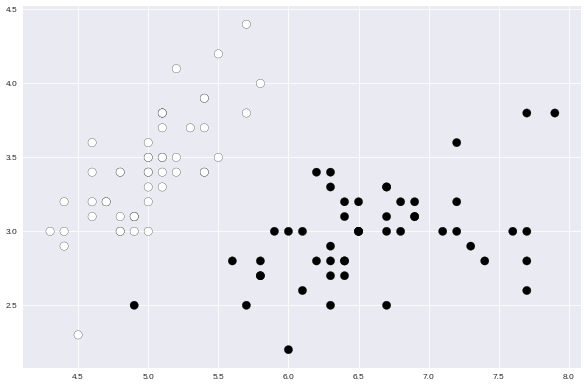

In [146]:
from sklearn.datasets import load_iris
iris = load_iris()

idx = np.in1d(iris.target, [0, 2])
X = iris.data[idx, 0:2]
y = iris.target[idx]

plt.figure(figsize=(12, 8), dpi=60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolor='k')
plt.show()

In [147]:
from sklearn.linear_model import Perceptron
import matplotlib as mpl
def plot_perceptron(n):
    plt.figure(figsize=(12, 8), dpi=60)
    model = Perceptron(n_iter=n, eta0=0.1, random_state=1).fit(X, y)
    XX_min = X[:, 0].min() - 1; XX_max = X[:, 0].max() + 1;
    YY_min = X[:, 1].min() - 1; YY_max = X[:, 1].max() + 1;
    XX, YY = np.meshgrid(np.linspace(XX_min, XX_max, 1000), np.linspace(YY_min, YY_max, 1000))
    ZZ = model.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
    cmap = mpl.colors.ListedColormap(sns.color_palette("Set2"))
    plt.contourf(XX, YY, ZZ, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], s=50, linewidth=2, edgecolor='k', c=y, cmap=cmap)
    plt.xlim(XX_min, XX_max)
    plt.ylim(YY_min, YY_max)
    plt.grid(False)
    plt.show()


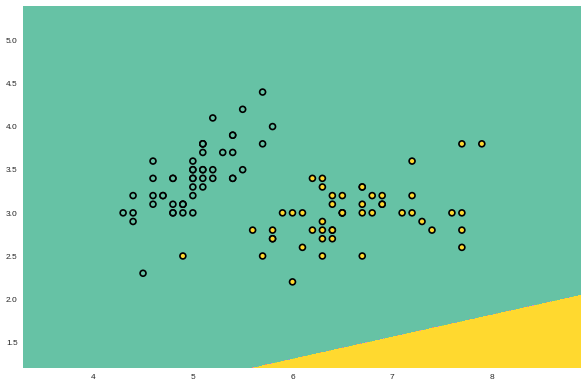

In [148]:
plot_perceptron(1)

In [149]:
from ipywidgets import widgets
widgets.interact(plot_perceptron, n=widgets.IntSlider(min=1,max=100,step=1,value=1));

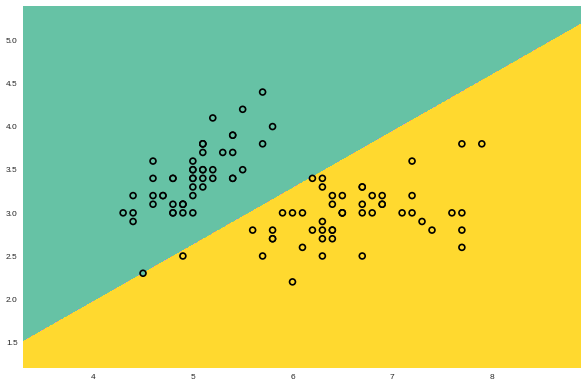

In [150]:
plot_perceptron(500)

In [151]:
from sklearn.metrics import confusion_matrix, classification_report

model = Perceptron(n_iter=500, eta0=0.1, random_state=1).fit(X, y)

In [152]:
confusion_matrix(y, model.predict(X))

array([[50,  0],
       [ 0, 50]])

## SGDClassifier 실행 예  


In [153]:
from sklearn.linear_model import SGDClassifier

def plot_sgd(n):
    plt.figure(figsize=(12, 8), dpi=60)
    model = SGDClassifier(loss="hinge", n_iter=n, random_state=1).fit(X, y)
    XX_min = X[:, 0].min() - 1; XX_max = X[:, 0].max() + 1;
    YY_min = X[:, 1].min() - 1; YY_max = X[:, 1].max() + 1;
    XX, YY = np.meshgrid(np.linspace(XX_min, XX_max, 1000), np.linspace(YY_min, YY_max, 1000))
    ZZ = model.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
    cmap = mpl.colors.ListedColormap(sns.color_palette("Set2"))
    plt.contourf(XX, YY, ZZ, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', linewidth=2, cmap=cmap)
    plt.xlim(XX_min, XX_max)
    plt.ylim(YY_min, YY_max)    
    plt.grid(False)
    plt.show()

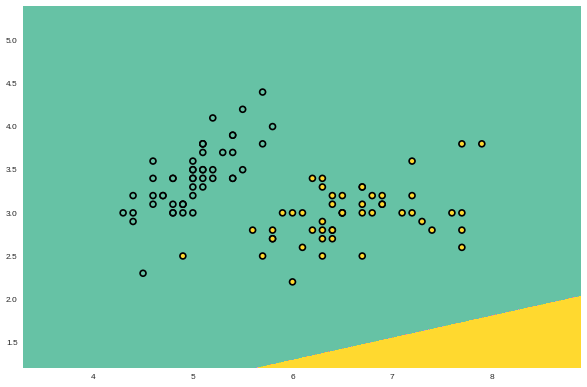

In [154]:
plot_sgd(1)

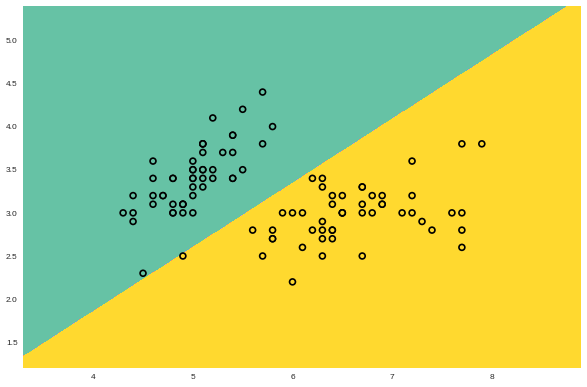

In [157]:
plot_sgd(51)

In [142]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [89]:
z = np.linspace(0, 1, 100)
x = z * np.sin(20*z)
y = z * np.cos(20*z)
c = x + y

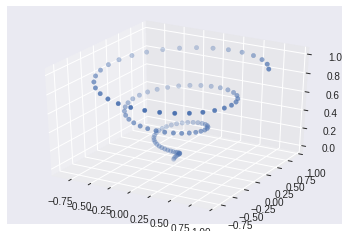

In [95]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter(x, y, z)

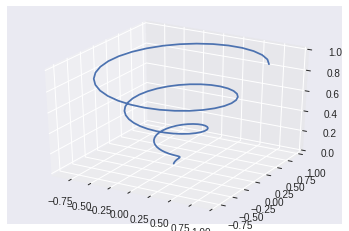

In [97]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(x, y, z)

In [98]:
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))

In [115]:
x[15]

array([ 0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552,
        0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552,
        0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552,
        0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552,
        0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552,
        0.06896552,  0.06896552,  0.06896552,  0.06896552,  0.06896552])

In [116]:
y = x.copy().T

In [117]:
y[15]

array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
       -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
       -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
        0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
        0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
        1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ])

In [118]:
z = np.cos(x ** 2 + y ** 2)

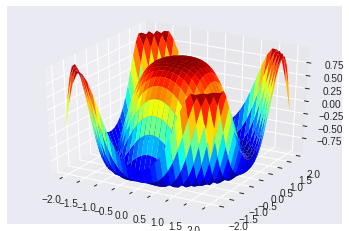

In [119]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)

# 서포트 벡터 머신

퍼셉트론은 가장 단순하고 빠른 판별 함수 기반 분류 모형이지만 판별 경계선(decision hyperplane)이 유니크하게 존재하지 않는다는 특징이 있다.

서포트 벡터 머신(SVM: support vector machine)은 퍼셉트론 기반의 모형에 가장 안정적인 판별 경계선을 찾기 위한 제한 조건을 추가한 모형이라고 볼 수 있다. 

<img src="https://datascienceschool.net/upfiles/632bf7973c904579954235a61cc340e1.png" style="width:100%; margin: 0 auto 0 auto;">

## 마진

판별 함수$f(x) = w^Tx-w_0$ 를 가지는 판별 함수 기반 모형의 판별 경계선은 다음과 같이 주어진다.

$$ w^T x - w_0 = 0 $$

이 수식은 경계선에서 0이 된다는 조건만 지키면 되기 때문에 가장 가까운 클래스 +1의 표본 데이터 $x^{+}$과 가장 가까운 클래스 -1의 표본 데이터 $x^{-}$의 값이 각각 1과 -1이 되도록 스케일링(scaling)할 수 있다.


$$ w^T x^{+} - w_0 = +1 $$


$$ w^T x^{-} - w_0 = -1 $$


이 판별 경계선과 표본 데이터 $x^{+}$, $x^{-}$ 사이의 거리는 다음과 같이 주어진다.

$$ \dfrac{w^T x^{+} - w_0}{\| w \|} $$

$$ -\dfrac{w^T x^{-} - w_0}{\| w \|} $$

[[school_notebook:dd1680bfbaab414a8d54dc978c6e883a]]

이 거리의 합을 마진(margin)이라고 하며 마진값이 클 수록 더 경계선이 안정적이라고 볼 수 있다. 그런데 위에서 정한 스케일링에 의해 마진은 다음과 같이 정리된다.

$$ \dfrac{w^T x^{+} - w_0}{\| w \|}  -\dfrac{w^T x^{-} - w_0}{\| w \|} = \dfrac{2}{\| w \|}$$

마진 값이 최대가 되는 경우는 $\| w \|$ 즉, $\| w \|^2$가 최소가 되는 경우와 같다.

또한 모든 표본 데이터에 대해 분류(classification)는 제대로 해야 하므로 모든 데이터 $(x_n, y_n)$에 대해 다음 조건을 만족해야 한다.
위에서 스케일링을 사용하여 모든 데이터에 대해 $w^Tx_n - w_o$ 가 1보다 크거나 -1보다 작게 만들었다는 점을 이용한다.

$$ y_n \cdot \hat{y}_n = y_n \cdot( w^Tx_n - w_o)\geq 1 $$

$$  g_n(x) = y_n \cdot ( w^Tx_n - w_o) - 1 \geq 0$$

Karush–Kuhn–Tucker 조건을 사용하면 최소화 목적 함수를 다음과 같이 고치면 된다.

$$ L = \dfrac{1}{2} ||w||^2 - \sum_{n=1}^N a_n g_n(x) $$

$$ L = \dfrac{1}{2} ||w||^2 - \sum_{n=1}^N a_n \{ y_n \cdot ( w^Tx_n - w_o) - 1 \} $$

여기에서 $a_n$은 $g_n(x)$에 대한 라그랑주 승수이다.

Karush–Kuhn–Tucker 조건은 라그랑주 승수 방법과 비슷하지만 조건을 만족시킬 필요가 없는 경우, 즉, $(w^Tx_n - w_o) - 1 \neq 0 $인 경우에는 $a= 0$이 된다.

## Dual Form

위 함수를 $w$, $w_0$ 로 미분하여 기울기가 0이되는 조건을 구하면 다음과 같다.

$$ 
w = \sum_{n=1}^N a_n y_n x_n
$$

$$ 
0 = \sum_{n=1}^N a_n y_n 
$$

이 조건을 대입하여 $w$, $w_0$을 없애면 다음과 같은 문제가 된다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m
$$
이 때 $a$는 다음 조건을 만족한다.
$$
\sum_{n=1}^N a_n y_n = 0, \;\;\; a_n \geq 0
$$

이 문제는 $w$를 구하는 문제가 아니라 $a$를 구하는 문제로 바뀌었으므로 dual form 이라고도 한다.


dual form 문제는 수치적으로 Box 제한 조건이 있는 이차 프로그래밍 문제(quadratic programming)가 되므로 적은 연산량으로 풀 수 있다.

## 서포트

dual form 문제를 풀어 함수 $L$ 를 최소화하는 $a$를 구하면 예측 모형을 다음과 같이 쓸 수 있다.

$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0
$$


이차 프로그래밍(최적화)로 구한 라그랑주 승수 값이 0 즉, $a_n = 0$ 이면 해당 데이터는 예측 모형, 즉 $w$ 계산에 아무런 기여를 하지 않는다는 것을 알 수 있다.

만약 $n$번째 데이터에 대해 $a_n > 0$ 이면 조건 만족을 위해 $y_n(w^Tx_n - w_o) = 1$이 된다. 즉 판별함수 값 $w^Tx_n - w_o = \pm 1$ 이다.

이러한 데이터를 서포트(support)라고 한다.



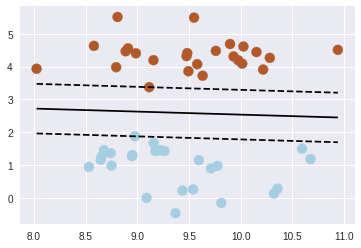

In [120]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=4, cluster_std=0.60)

xmin = X[:,0].min()
xmax = X[:,0].max()
ymin = X[:,1].min()
ymax = X[:,1].max()
xx = np.linspace(xmin, xmax, 10)
yy = np.linspace(ymin, ymax, 10)
X1, X2 = np.meshgrid(xx, yy)

def plot_svm(model):
    Z = np.empty(X1.shape)
    for (i, j), val in np.ndenumerate(X1):
        x1 = val
        x2 = X2[i, j]
        p = model.decision_function([[x1, x2]])
        Z[i, j] = p[0]
    levels = [-1.0, 0.0, 1.0]
    linestyles = ['dashed', 'solid', 'dashed']
    plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=plt.cm.Paired)
    plt.contour(X1, X2, Z, levels, colors='k', linestyles=linestyles)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150, linewidth=3, facecolors='none')
    plt.show()

from sklearn.svm import SVC

model = SVC(kernel='linear').fit(X, y)
plot_svm(model)

In [121]:
x_new = [10, 2]
model.decision_function([x_new])

array([-0.70648511])

In [122]:
model.coef_.dot(x_new) + model.intercept_

array([-0.70648511])

In [123]:
model.support_vectors_

array([[ 8.97646441,  1.87283258],
       [ 9.11476202,  3.37056244]])

In [124]:
model.support_

array([42,  1], dtype=int32)

In [125]:
y[model.support_]

array([0, 1])

In [126]:
# dual_coef_ = y_i \alpha_i
model.dual_coef_[0][0] * model.support_vectors_[0].dot(x_new) + \
model.dual_coef_[0][1] * model.support_vectors_[1].dot(x_new) + \
model.intercept_

array([-0.70648511])

In [127]:
y[model.support_][1]

1

In [128]:
model.n_support_ 

array([1, 1], dtype=int32)

## 슬랙 변수

만약 데이터가 직선인 판별 경계선으로 나누어지지 않는 즉, 선형 분리(linear separable)가 불가능 한 경우에는 다음과 같이 슬랙 변수(slack variable)를 사용하여 개별적인 오차를 허용할 수 있다.

원래 판별 함수의 값은,

클래스 $+1$ 영역의 샘플 $x_{+}$에 대해 

$$ w^Tx_{+} - w_0 \geq 1 $$  

클래스 $-1$ 영역의 샘플 $x_{-}$에 대해 
 
$$ w^Tx_{-} - w_0 \leq -1 $$

이어야 한다.
 

양수인 슬랙 변수 $\xi \geq 0 $를 사용하면 이 조건을 다음과 같이 완화할 수 있다.


$$ w^Tx_{+} - w_0 \geq +1-\xi_i $$

$$ w^Tx_{-} - w_0 \leq -1+\xi_i $$

$$ \xi \geq 0 $$

대신 슬랙 변수의 크기를 제한해야 하므로 위의 부등식 조건을 모두 고려한 최적화 목적 함수는 다음과 같아진다.

$$ 
L = \dfrac{1}{2} ||w||^2 - \sum_{n=1}^N a_n (y_n \cdot ( w^Tx_n - w_o) - 1 + \xi_n ) - \sum_{n=1}^N \mu_n \xi_n  + C \sum_{n=1}^N \xi_n    $$

마지막항은 optimize해야 할 목적함수로 봐주어야 할 허용치의 한계이다.


<img src="https://datascienceschool.net/upfiles/d5735e8d8db342858166a790f108e8fc.png" style="width:100%; margin: 0 auto 0 auto;">

SVM은 데이터를 아무리 많이 줘도 두 포인트만을 사용한다. 그러나 fitting시에는 가장 가까운 둘을 찾아야 하므로 시간이 소요된다. Fitting은 연산이 필요하나 prediction은 마이크로프로세서 수준에서 처리가 가능하다. 따라서 간단한 지문인식 등에 많이 활용된다.

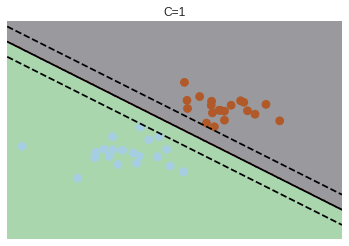

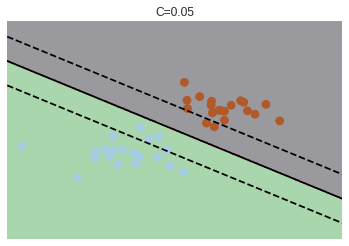

In [129]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

fignum = 1
for name, penalty in (('C=1', 1), ('C=0.05', 0.05)):
    clf = SVC(kernel='linear', C=penalty).fit(X, Y)
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin
    
    plt.figure(fignum)
    
    x_min = -5
    x_max = 5
    y_min = -9
    y_max = 9
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.6)

    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=120, linewidth=4, facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=60, linewidth=1, cmap=plt.cm.Paired)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    plt.axis('tight')
    plt.show()
    
    fignum = fignum + 1;

## 얼굴 이미지 인식

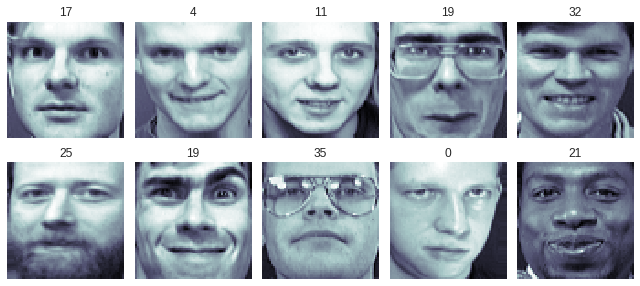

In [159]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

N=2; M=5;
np.random.seed(0)
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
klist = np.random.choice(range(len(faces.data)), N * M)
for i in range(N):
    for j in range(M):
        k = klist[i*M+j]
        ax = fig.add_subplot(N, M, i*M+j+1)
        ax.imshow(faces.images[k], cmap=plt.cm.bone);
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title(faces.target[k])
plt.tight_layout()
plt.show()

In [160]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.25, random_state=0)

In [161]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear').fit(X_train, y_train)

In [170]:
cf_mat = confusion_matrix(y_test, svc_1.predict(X_test))
print(cf_mat)
print("# Test Set: ", y_test.shape)
print("Accuracy: ", cf_mat.trace()/y_test.shape[0])

[[6 0 0 ..., 0 0 0]
 [0 4 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 3]]
# Test Set:  (100,)
Accuracy:  0.99


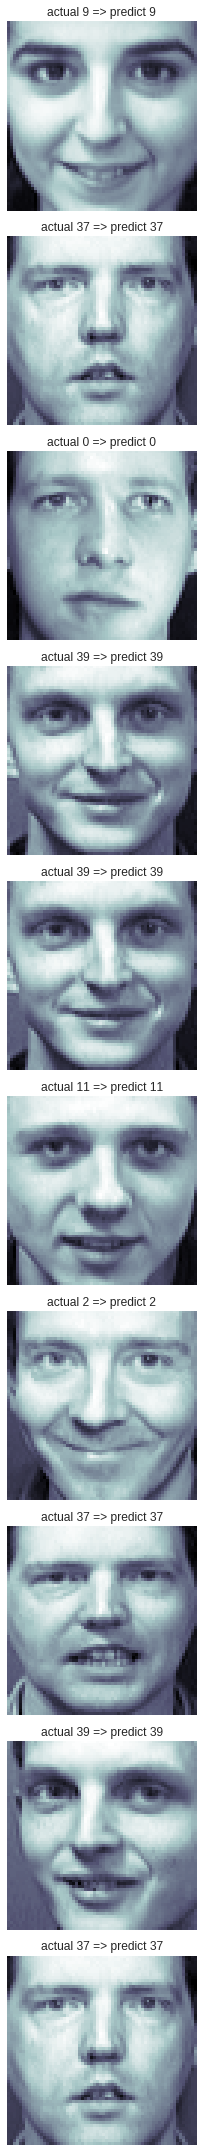

In [133]:
fig = plt.figure(figsize=(3,30))
for i, k in enumerate(np.random.choice(len(y_test), 10)):
    ax = fig.add_subplot(10, 1, i + 1)
    ax.imshow(X_test[k:(k+1), :].reshape(64,64), cmap=plt.cm.bone);
    ax.grid(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.title("actual %d => predict %d" % (y_test[k], svc_1.predict(X_test[k:(k+1), :])[0]))
plt.tight_layout()
plt.show()    

In [134]:
glasses = [
    ( 10,  19), ( 30,  32), ( 37,  38), ( 50,  59), ( 63,  64),
    ( 69,  69), (120, 121), (124, 129), (130, 139), (160, 161),
    (164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
    (194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
    (330, 339), (358, 359), (360, 369)
]

def create_target(segments):
    y = np.zeros(faces.target.shape[0])
    for (start, end) in segments:
        y[start:end + 1] = 1
    return y

target_glasses = create_target(glasses)
X_train, X_test, y_train, y_test = train_test_split(faces.data, target_glasses, test_size=0.25, random_state=0)

In [135]:
svc_2 = SVC(kernel='linear').fit(X_train, y_train)

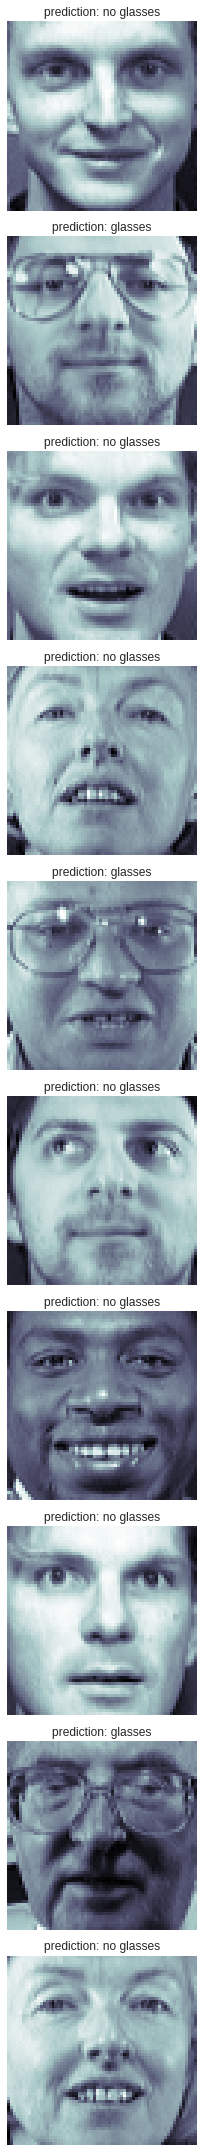

In [137]:
fig = plt.figure(figsize=(3,30))
for i, k in enumerate(np.random.choice(len(y_test), 10)):
    ax = fig.add_subplot(10, 1, i + 1)
    ax.imshow(X_test[k:(k+1), :].reshape(64,64), cmap=plt.cm.bone);
    ax.grid(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    plt.title("prediction: %s" %  ("glasses" if (svc_2.predict(X_test[k:(k+1), :])[0]) else "no glasses"))
plt.tight_layout()
plt.show()        

# 커널 서포트 벡터 머신

## XOR 문제

퍼셉트론이나 서포트 벡터 머신과 같은 선형 판별 함수 기반 모형은 다음과 같은 XOR(exclusive OR) 문제를 풀지 못한다는 단점이 있다. 

| | X2=0 | X2=1 |
|-|-|-|
|X1=0| 0 | 1 |
|X1=1| 1 | 0 | 

이러한 경우에는 선형 판별 평면(decision hyperplane)으로 영역을 나눌 수 없기 때문이다.

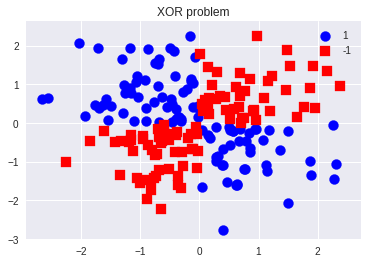

In [171]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='o', label='1', s=100)
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1', s=100)
plt.ylim(-3.0)
plt.legend()
plt.title("XOR problem")
plt.show()

In [172]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y== 1, 0], X[y== 1, 1], c='b', marker='o', label='+1', s=100)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

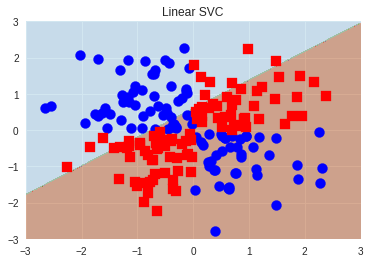

In [173]:
from sklearn.svm import SVC

svc = SVC(kernel="linear").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, "Linear SVC")

## 기저 함수를 사용한 비선형 판별 모형

이러한 경우 도움이 되는 것이 원래의 $D$ 차원 독립 변수 벡터 $x$ 대신 기저 함수(basis function)으로 변환한 $M$ 차원 벡터 $\phi(x)$를 독립 변수 벡터로 사용하는 방법이다.

$$ \phi(\cdot): \mathbf{R}^D \rightarrow \mathbf{R}^M $$

$$ x=(x_1, x_2, \cdots, x_D) \;\;\; \rightarrow \;\;\; \phi(x) = (\phi_1(x), \phi_2(x), \cdots, \phi_M(x)) $$

앞서 XOR 문제를 풀기 위해 다음과 같이 상호 곱(cross-multiplication) 항을 추가한 기저 함수를 사용해 보자.


$$ (x_1, x_2) \;\;\; \rightarrow \;\;\; \phi(x) = (x_1^2, \sqrt{2}x_1x_2, x_2^2) $$

In [174]:
from sklearn.preprocessing import FunctionTransformer

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1], X[:, 1]**2]).T

X = np.arange(8).reshape(4, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [175]:
FunctionTransformer(basis).fit_transform(X)

array([[  0.        ,   0.        ,   1.        ],
       [  4.        ,   8.48528137,   9.        ],
       [ 16.        ,  28.28427125,  25.        ],
       [ 36.        ,  59.39696962,  49.        ]])

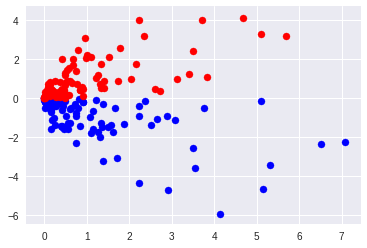

In [176]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor== 1, 0], X_xor2[y_xor== 1, 1], c="b", s=50)
plt.scatter(X_xor2[y_xor==-1, 0], X_xor2[y_xor==-1, 1], c="r", s=50)
plt.show()

## 커널 트릭

서포트 벡터 머신의 경우 목적 함수와 예측 모형은 다음과 같은 dual form으로 표현할 수 있다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0
$$

이 수식에서 $x$를 기저함수 변환으로 $\phi(x)$로 바꾸면

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \phi(x_n)^T \phi(x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n \phi(x_n)^T \phi(x) - w_0
$$

이 된다. 즉 모든 기저함수는 $\phi(x_i)^T\phi(x_j)$의 형태로만 사용되며 독립적으로 사용되지 않는다.

**즉 내적한 형태로만 사용되므로 basis로 접근하지 말고 아예 얘네의 내적값을 kernel이라는 이름으로 정의하여 사용하자**

따라서 두 개의 변환된 독립 변수 벡터를 내적(inner product) 한 값 $\phi(x_i)^T\phi(x_j)$를 하나의 함수로 나타낼 수 있다.

$$ k(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

이러한  함수를 커널(kernel)이라고 한다.

대응하는 기저함수가 존재할 수만 있다면 기저함수를 먼저 정의하고 커널을 정의하는 것이 아니라 커널을 먼저 정의해도 상관없다.  

## 커널의 의미

서포트 벡터 머신의 목적 함수와 예측 모형은 커널을 사용하여 표현하면 다음과 같다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m k(x_n, x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n k(x_n, x) - w_0
$$

커널을 사용하지 않는 경우 $ k(x, y) = x^Ty $라는 점을 고려하면 커널은 다음과 같은 특징을 보인다.

* $x$와 $y$가 동일한 벡터일 때 가장 크고
* 두 벡터간의 거리가 멀어질 수록 작아진다.

**즉, 두 표본 데이터 간의 유사도(similarity)를 측정하는 기준으로 볼 수도 있다. **

## 커널 사용의 장점

커널을 사용하면 베이시스 함수를 하나씩 정의하는 수고를 덜 수 있을뿐더러 변환과 내적에 들어가는 계산량이 줄어든다. 예를 들어, 다음과 같은 기저함수의 경우

$$ \phi(x_i) = \phi([x_{i,1}, x_{i,2}]) = (x_{i,1}^2, \sqrt{2}x_{i,1}x_{i,2}, x_{i,2}^2) $$

커널 방법을 쓰지 않을 경우에 $ \phi(x_i)^T \phi(x_j) $를 계산하려면 $4 + 4 + 3 = 11$ 번의 곱셈을 해야 한다.

* $\phi(x_1)$ 계산 : 곱셈 4회
* $\phi(x_2)$ 계산 : 곱셈 4회
* 내적: 곱셈 3회

그런데 이 기저함수는 다음과 같은 커널로 대체가능하다.

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2)^2 \\
&=& (x_{1,1}x_{2,1} + x_{1,2}x_{2,2})^2 \\
&=& x_{1,1}^2x_{2,1}^2 + 2x_{1,1}x_{2,1}x_{1,2}x_{2,2} + x_{1,2}^2y_{2,2}^2 \\
&=& (x_{1,1}^2, \sqrt{2}x_{1,1}x_{1,2}, x_{1,2}^2)  (x_{2,1}^2, \sqrt{2}x_{2,1}x_{2,2}, x_{2,2}^2)^T \\
&=& \phi(x_1)^T \phi(x_2)
\end{eqnarray}
$$


커널을 사용하면  $ \phi(x_1)^T \phi(x_2) $ 을 계산하는데 $2 + 1 = 3$ 번의 곱셈이면 된다.
 
* $x_1^Tx_2$: 곱셈 2회
* 제곱: 곱셈 1회

## 많이 사용되는 커널

다음과 같은 커널들이 많이 사용되는 커널들이다. 이 커널들은 대부분 기저함수로 변환하였을 때 무한대의 차원을 가지는 기저 함수가 된다. 따라서 대부분의 비선형성을 처리할 수 있다.


* 커널을 사용하지 않는 경우

$$ k(x_1, x_2) = x_1^Tx_2 $$


* 다항 커널 (Polynomial Kernel)

$$ k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d $$


* RBF(Radial Basis Function) 또는 가우시안 커널 (Gaussian Kernel)

$$ k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right) $$


* 시그모이드 커널 (Sigmoid Kernel)

$$ k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta) $$


앞에서 사용한 기저함수는 $\gamma = 1, \theta= 0, d=2$ 인 다항 커널임을 알 수 있다.

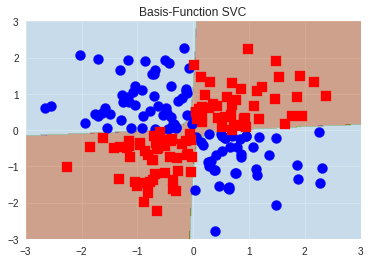

In [177]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([("basis", FunctionTransformer(basis)), ("svc", SVC(kernel="linear"))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, "Basis-Function SVC")

다음과 같은 커널들이 많이 사용되는 커널들이다. 이 커널들은 대부분 기저함수로 변환하였을 때 무한대의 차원을 가지는 기저 함수가 된다. 따라서 대부분의 비선형성을 처리할 수 있다.


* 커널을 사용하지 않는 경우

$$ k(x_1, x_2) = x_1^Tx_2 $$


* 다항 커널 (Polynomial Kernel)

$$ k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d $$


* RBF(Radial Basis Function) 또는 가우시안 커널 (Gaussian Kernel)

$$ k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right) $$


* 시그모이드 커널 (Sigmoid Kernel)

$$ k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta) $$


앞에서 사용한 기저함수는 $\gamma = 1, \theta= 0, d=2$ 인 다항 커널임을 알 수 있다.

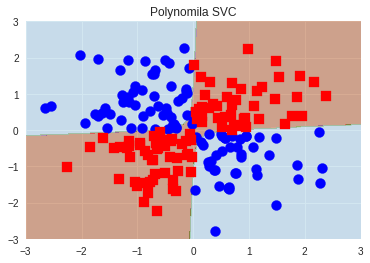

In [178]:
polysvc = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, polysvc, "Polynomila SVC")

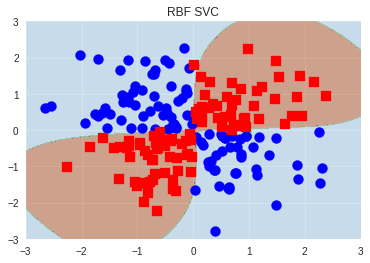

In [179]:
rbfsvc = SVC(kernel="rbf").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, rbfsvc, "RBF SVC")

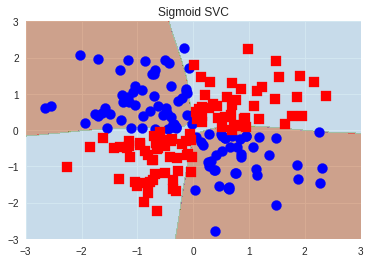

In [180]:
sigmoidsvc = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, sigmoidsvc, "Sigmoid SVC")

## 커널 파라미터

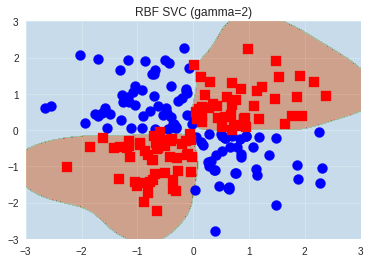

In [183]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=2).fit(X_xor, y_xor), "RBF SVC (gamma=2)")

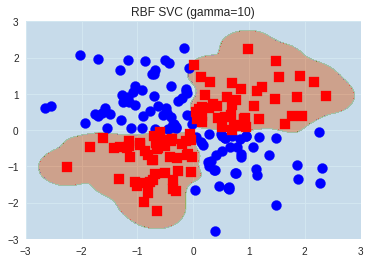

In [184]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=10).fit(X_xor, y_xor), "RBF SVC (gamma=10)")

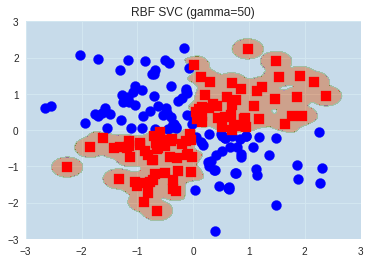

In [185]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVC (gamma=50)")

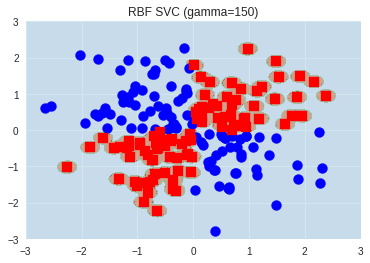

In [191]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=150).fit(X_xor, y_xor), "RBF SVC (gamma=150)")

## 예 : Iris 

In [186]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y==2, 0], X[y==2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

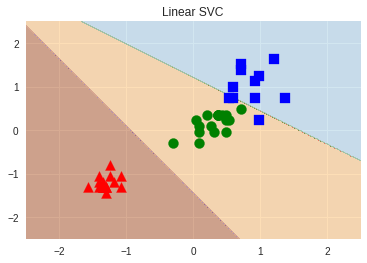

In [187]:
model = SVC(kernel='linear').fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "Linear SVC")

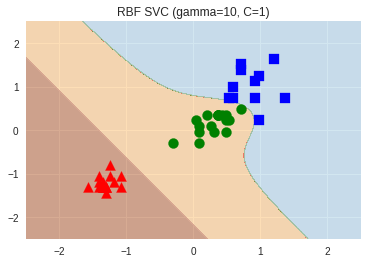

In [188]:
model = SVC(kernel='poly', random_state=0, gamma=10, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "RBF SVC (gamma=10, C=1)")

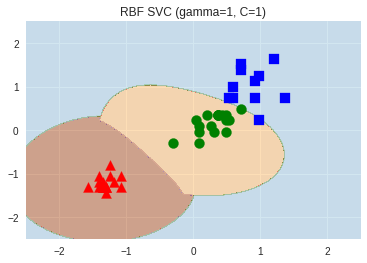

In [189]:
model = SVC(kernel='rbf', random_state=0, gamma=1, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "RBF SVC (gamma=1, C=1)")